In [17]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [18]:
#Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [19]:
# Diretório onde estão armazenadas as imagens
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [20]:
# Function to load and resize images
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)  # Open the image file
        image = image.resize(target_size)  # Resize the image to the target size
        return np.array(image) / 255.0  # Convert to a NumPy array and normalize
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [21]:
# Carregar IDs do grupo de treinamento de um arquivo de texto
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [22]:
# Carregar IDs do grupo de validação de um arquivo de texto
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [23]:
%%capture
# Lists to store image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Error loading JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"Sample ID missing in JSON: {json_path}")
            continue
        
        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Image file not found: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Key 'classes' missing or empty in JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [24]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 642
Número de imagens de validação carregadas: 214


In [25]:
# Separar as imagens e os rótulos (labels)
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [26]:
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [27]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [28]:
# Converter os rótulos em formato adequado (numérico)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [29]:
# Codificação one-hot para os rótulos
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [30]:
# Carregar o modelo base VGG16 com pesos pré-treinados da ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [31]:
# Congelar as camadas da VGG16 para treinar apenas as camadas personalizadas
base_model.trainable = False

In [32]:
# Adicionar novas camadas no topo do modelo base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [33]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
# Fine-tuning 
# Descongelar as últimas camadas da VGG16 para fazer fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [35]:
# Recompilar o modelo 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [36]:
# Treinamento do modelo com fine-tuning
history_finetune = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
21/21 [==============================] - 61s 3s/step - loss: 1.2205 - accuracy: 0.4003 - val_loss: 0.8758 - val_accuracy: 0.6636
Epoch 2/20
21/21 [==============================] - 57s 3s/step - loss: 0.8897 - accuracy: 0.6059 - val_loss: 0.7677 - val_accuracy: 0.7570
Epoch 3/20
21/21 [==============================] - 58s 3s/step - loss: 0.7699 - accuracy: 0.6931 - val_loss: 0.6664 - val_accuracy: 0.7477
Epoch 4/20
21/21 [==============================] - 69s 3s/step - loss: 0.6665 - accuracy: 0.7632 - val_loss: 0.7361 - val_accuracy: 0.7430
Epoch 5/20
21/21 [==============================] - 74s 4s/step - loss: 0.6236 - accuracy: 0.7819 - val_loss: 0.6220 - val_accuracy: 0.8131
Epoch 6/20
21/21 [==============================] - 73s 4s/step - loss: 0.5816 - accuracy: 0.8006 - val_loss: 0.5289 - val_accuracy: 0.8458
Epoch 7/20
21/21 [==============================] - 74s 4s/step - loss: 0.5322 - accuracy: 0.8084 - val_loss: 0.5103 - val_accuracy: 0.8458
Epoch 8/20
21/21 [==

In [37]:
# Salvar o modelo treinado
model.save('trained_model.vgg16_vague_resolution')

INFO:tensorflow:Assets written to: trained_model.vgg16_vague_resolution\assets


INFO:tensorflow:Assets written to: trained_model.vgg16_vague_resolution\assets


In [38]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

7/7 [==============================] - 5s 747ms/step - loss: 0.3689 - accuracy: 0.8785
Loss no conjunto de validação: 0.368906170129776
Accuracy no conjunto de validação: 0.8785046935081482


In [39]:
# Previsões e relatórios
from sklearn.metrics import confusion_matrix, classification_report

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=label_encoder.classes_)
print("Relatório de Classificação:")
print(class_report)

7/7 [==============================] - 5s 750ms/step
Matriz de Confusão:
[[95  6  0]
 [ 1 92  0]
 [ 2 17  1]]
Relatório de Classificação:
              precision    recall  f1-score   support

      E.coli       0.97      0.94      0.95       101
P.aeruginosa       0.80      0.99      0.88        93
    S.aureus       1.00      0.05      0.10        20

    accuracy                           0.88       214
   macro avg       0.92      0.66      0.64       214
weighted avg       0.90      0.88      0.84       214



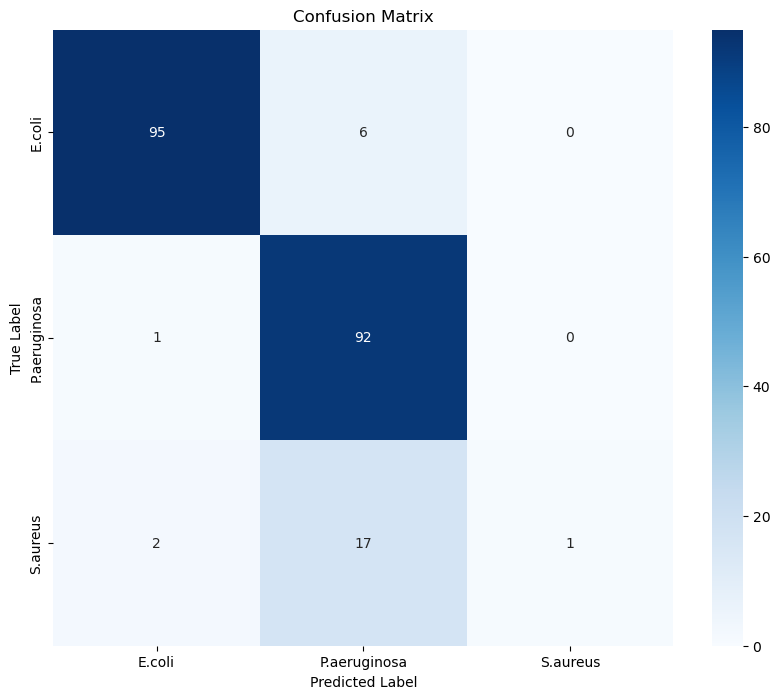

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()